In [1]:
import torch 
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch import nn
from pytorch_lightning import LightningModule
from torchmetrics import Accuracy
from torchdiffeq import odeint_adjoint as odeint
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from math import pi as pi
import numpy as np
import os
from torch.utils import data
from scipy.integrate import odeint as odeint_sym
import math
import torch.linalg as linalg
import torch.autograd.functional as AGF
device = torch.device('cuda',index=2) 
import control as ct

In [24]:
def Ian_machester_example(z, t):  # define the ode function
    z1, z2, z3 = z
    

    # (pi/4, 0)
    dz1 = -z1 + z3
    dz2 = z1**2 - z2 - 2*z1*z3 + z3
    dz3 = -z2
    dz = np.array([dz1, dz2, dz3])
    return dz

t_i = 0 
t_end = 30.0 
n_steps = 100 
time_vector = np.linspace(t_i, t_end, n_steps)
min = 2.5
max = 2.5
initial_positions_vector = np.random.uniform(low=min, high= max, size=(1,1))
initial_velocity_vector  = np.random.uniform(low=min, high= max, size=(1,1))
initial_velocity_vector2  = np.random.uniform(low=min, high= max, size=(1,1))
z0_vector = np.concatenate((initial_positions_vector,initial_velocity_vector,initial_velocity_vector2),axis=1)
print(z0_vector[0])
z_temp = odeint_sym(Ian_machester_example, z0_vector[0], time_vector)


[2.5 2.5 2.5]


/home/mzakwan/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


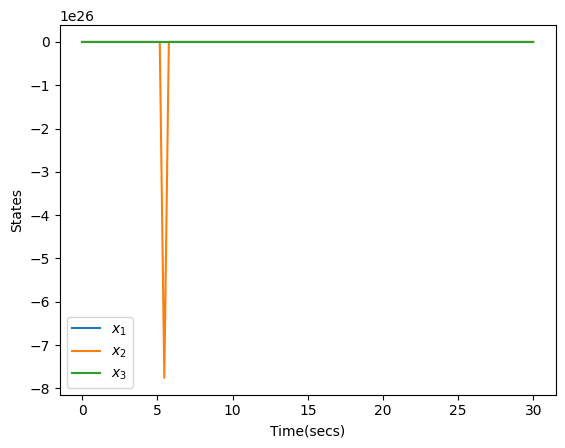

In [25]:
plt.figure()
plt.plot(time_vector, z_temp[:,0])
plt.plot(time_vector, z_temp[:,1])
plt.plot(time_vector, z_temp[:,2])
plt.xlabel('Time(secs)')
plt.ylabel('States')
plt.legend(['$x_1$','$x_2$','$x_3$'])
plt.show()



In [4]:
A = np.array([[-1.0, 0.0, 1.0],
              [0.0, -1.0, 1.0],
              [0.0, -1.0, 0.0]])

B = np.array([[0.0],[0.0],[1.0]])

Q = np.diag([1, 1, 1])
R = np.diag([1])

K, X, E = ct.lqr(A, B, Q, R)

print("K=",K.shape)

# print(X)

# print(E)

K= (1, 3)


# Defining the closed-loop with LQR

In [57]:
def Ian_machester_example(z, t):  # define the ode function
    z1, z2, z3 = z
    zz= z.reshape(3,1)
    u = np.matmul(K,zz).squeeze(-1).squeeze(-1)
    # print(u.shape)
    # (pi/4, 0)
    # print(zz.shape)
  
    dz1 = -z1 + z3
    dz2 = z1**2 - z2 - 2*z1*z3 + z3
    dz3 = -z2 + -u
    dz = np.array([dz1, dz2, dz3])
    return dz

t_i = 0 
t_end = 10.0
n_steps = 100 
time_vector_lqr = np.linspace(t_i, t_end, n_steps)
min = 10.0
max = 10.0
initial_positions_vector = np.random.uniform(low=min, high= max, size=(1,1))
initial_velocity_vector  = np.random.uniform(low=min, high= max, size=(1,1))
initial_velocity_vector2  = np.random.uniform(low=min, high= max, size=(1,1))
z0_vector = np.concatenate((initial_positions_vector,initial_velocity_vector,initial_velocity_vector2),axis=1)
z_temp_lqr = odeint_sym(Ian_machester_example, z0_vector[0], time_vector)

/home/mzakwan/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


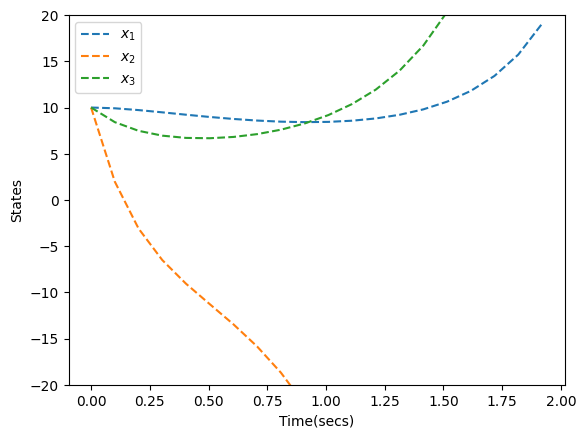

In [58]:
plt.figure()
plt.plot(time_vector_lqr[0:20], z_temp_lqr[0:20,0],'--')
plt.plot(time_vector_lqr[0:20], z_temp_lqr[0:20,1],'--')
plt.plot(time_vector_lqr[0:20], z_temp_lqr[0:20,2],'--')
plt.xlabel('Time(secs)')
plt.ylabel('States')
plt.legend(['$x_1$','$x_2$','$x_3$'])
plt.ylim([-20,20])
plt.show()


### Defining the NN controller

In [7]:
class Controller(nn.Module):

    def __init__(self):
        super(Controller, self).__init__()

        self.dim = 64
        self.fc1 = nn.Linear(3,self.dim, bias = None)
        self.fc2 = nn.Linear(self.dim,self.dim,bias = None)
        self.fc3 = nn.Linear(self.dim,1,bias = None)

        my_init_weight = -1.0*torch.eye(self.dim)
        with torch.no_grad():
        #     
                self.fc2.weight.copy_(my_init_weight)
    
    def smooth_leaky_relu(self, x):
        alpha = 0.3
        return alpha*x+(1 - alpha) * torch.log(1+torch.exp(x))
    
    def forward(self,x):
        x = self.smooth_leaky_relu(self.fc1(x))
        x = self.smooth_leaky_relu(self.fc2(x))
        x = self.smooth_leaky_relu(self.fc3(x))
        return x
    
   


tensor([[ 0.0000],
        [-0.2500],
        [-0.5148]], device='cuda:2', grad_fn=<ReshapeAliasBackward0>)


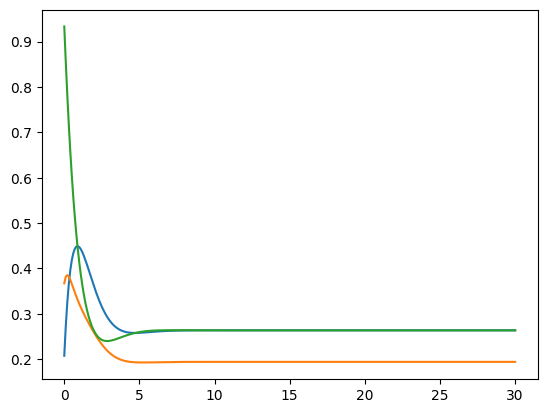

In [8]:
tol = 1e-7 
endtime = 30.0


controller = Controller().to(device)

class closed_loop(nn.Module):

    def __init__(self, controller):
        super(closed_loop, self).__init__()
        self.controller = controller
        self.K = torch.tensor(K).to(device).float()

    def forward(self,t, z):
        u_NN = controller(z.T)
        z1, z2, z3 = z
        zz= z.reshape(3,1)
        u = self.K @ z
        
    

        dz1 = -z1 + z3
        dz2 = z1**2 - z2 - 2*z1*z3 + z3
        dz3 = -z2 - u.squeeze(-1) + u_NN.squeeze(-1)
        dz =  torch.cat((dz1, dz2, dz3), dim=0).reshape(3,1) 
        return dz

closed_loop_pendulum = closed_loop(controller).to(device)
x_star = torch.tensor([[0.5],[0.5],[0.5]]).to(device)
print(closed_loop_pendulum(0.0,x_star))
x0 = torch.rand(3,1).to(device)
time_vec = torch.linspace(0,endtime,300).to(device)
out = odeint(closed_loop_pendulum, x0, time_vec, rtol=tol, atol=tol, method="rk4")

plt.figure()
plt.plot(time_vec.cpu(), out[:,0,:].cpu().detach().numpy())
plt.plot(time_vec.cpu(), out[:,1,:].cpu().detach().numpy())
plt.plot(time_vec.cpu(), out[:,2,:].cpu().detach().numpy())
plt.show()

# Defining the handlers

In [9]:
def func1(L,U,W):
    """
    This function calculates the lower  \tilde{L} and upper bounds  \tilde{U} of W \times Q, given the element-wise upper bound matrix U and
    lower bound matrix L of Q, and the matrix W
    """
    W_plus_mask = torch.where((W > 0), 1.0, 0.0).to(device)
    W_minus_mask = torch.where((W < 0), 1.0, 0.0).to(device)
    W_plus = W_plus_mask.to(device)  * W.to(device) 
    W_minus = W_minus_mask.to(device)  * W.to(device)

    L_tilde = W_plus @ L + W_minus @ U
    U_tilde = W_plus @ U + W_minus @ L
    return L_tilde, U_tilde


def func2(L_tilde, U_tilde,a,b):
    """
    This function calculates the lower \hat{L} and upper bounds \hat{U} of J \times P, where P is an arbitrary matrix. Given the
    element-wise upper bound matrix  \tilde{U} and lower bound matrix  \tilde{L} of P, and a, b.
    """
    # 0 < a < b 
    mask1 = torch.where( ((U_tilde > L_tilde ) | (U_tilde == L_tilde ))  & (L_tilde >= 0),1.0, 0.0 ).to(device)
    mask2 = torch.where(  (U_tilde >= 0) & (L_tilde<=0),1.0, 0.0 ).to(device)
    mask3 = torch.where(  ( U_tilde<=0) & ((U_tilde == L_tilde)|(U_tilde > L_tilde)), 1.0, 0.0 ).to(device)
    # print(mask1 + mask2 + mask3)
    L_hat = a*mask1*L_tilde + b*mask2*L_tilde + b*mask3*L_tilde
    U_hat = b*mask1*U_tilde + b*mask2*U_tilde + a*mask3*U_tilde
    
    
    return L_hat, U_hat

# Pytorch Lightening classifier

In [10]:

class ImageClassifier(LightningModule):
    def __init__(self, regularizer_weight,reg_flag):
        super().__init__()
        self.save_hyperparameters()
        self.net = controller
        self.reg_flag = reg_flag
        self.regularizer_weight = regularizer_weight

        self.loss_func =  nn.MSELoss()

    def forward(self, x):
        return self.net(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1.5e-3, eps=1e-2)
        # optimizer = torch.optim.AdamW(self.net.parameters(), lr=1e-2)
        
        return [optimizer]

    def regularization(self):
            # L = torch.eye(self.net[0].odefunc.hidden_layers[0].weight.shape[0]).to(device)
            # U = torch.eye(self.net[0].odefunc.hidden_layers[0].weight.shape[0]).to(device)

            # define the constants
            kappa_1 = 0.3
            kappa_2 = 1.0
            lambda_max_f = 0.0332
            rho = 1.0 + 2*lambda_max_f# contarction rate
            g = torch.tensor([[0.0],[0.0],[1.0]])

            
            x_star = torch.tensor([[0.0],[0.0],[0.0]],requires_grad=True,
                              dtype=torch.float32).to(device)
        #     equilibrium_grad = AGF.jacobian(lyapunov_fcn, torch.stack((q_star, p_star)), create_graph=True)
            
            equilibrium_assignment = torch.norm(closed_loop_pendulum(0.0,x_star).to(device))

        # # ! I can require the hessian to be greater than a*I, to improve the positiveness of hessian
        #     equilibrium_hessian = AGF.hessian(lyapunov_fcn, torch.stack((q_star, p_star)), create_graph=True)-0.5*torch.eye(2).to(self.device)

        #     minimum_condition = F.relu(-torch.min(torch.real(linalg.eigvals(equilibrium_hessian))))


            # print(self.net[0].odefunc.weight) ma chère  t'es la(e) meilleur(e)
            # Calculating the lower and upper bound
            L = torch.eye(self.net.fc1.weight.shape[1]).to(device)
                    # print("L shape", L.shape)
            U = torch.eye(self.net.fc1.weight.shape[1]).to(device)

            for name, param in self.net.named_parameters():
                if 'weight' in name:
                
                
                    weights = param.to(device)
                    
                    # print("U shape", U.shape)
                    L_tilde, U_tilde = func1(L,U,weights)
                    # print("L_tilde shape", L_tilde.shape)
                    # print("U_tilde shape", U_tilde.shape)
                    L_hat, U_hat = func2(L_tilde, U_tilde,a=kappa_1,b=kappa_2)
                    # print("L_hat shape", L_hat.shape)
                    # print("U_hat shape", U_hat.shape)
                    L = L_hat
                    U = U_hat
                    # print(L.shape)
                    # print(U.shape)
                
            L_tilde, U_tilde = func1(L,U,g)
            L = L_tilde
            U = U_tilde
            sum_off_U = torch.sum(torch.abs(U),dim =1) - torch.abs(torch.diag(U,0))
            sum_off_L = torch.sum(torch.abs(L),dim =1) - torch.abs(torch.diag(L,0))
          
            offdiag =  rho + 2*torch.diagonal(U, 0) + torch.maximum(sum_off_U, sum_off_L)
         
            reg = torch.relu(offdiag.mean()) #+ torch.relu(offdiag_2.max())
            return reg +  equilibrium_assignment

    def training_step(self, batch):
    
        
        loss = self.regularization()
        self.log("loss_cont", loss, prog_bar=True)
        return loss

    # def test_step(self, batch, batch_idx):

    #     local_x0s, local_ys = batch
    #     local_ys = torch.permute(local_ys, [1, 0, 2])
    #     actual_batch_size = local_x0s.shape[0]
    #     # print("shape of x0", local_x0s.shape)
    #     # print("shape of output", local_ys.shape)
    #     x_sim = self.net[0].node_propagation(local_x0s) 
    #     # print("shape of x_sim", x_sim.shape)
    #     test_loss = self.loss_func(x_sim, local_ys)
    #     self.log("test_loss", test_loss, prog_bar=True)
    #     return test_loss

# Define Trainer and dummy dataset

In [11]:
# Need a dummy data set for the pytorch lightening module  
if __name__ == '__main__':

    class TrainDataset(Dataset):
        def __init__(self, q_range, p_range):

            grid_q, grid_p = torch.meshgrid(
                q_range, p_range)

            self.q_data = grid_q.reshape(-1,)
            self.p_data = grid_p.reshape(-1,)

        def __len__(self):
            return len(self.q_data)

        def __getitem__(self, idx):

            return self.q_data[idx], self.p_data[idx]
        

    training_data = TrainDataset(
        torch.linspace(1/4-2, 1/4+2, 1), torch.linspace(-2, 2, 1))

    train_dataloader = DataLoader(
        training_data, batch_size=1, num_workers=30, persistent_workers=True)

    global_data_size = 1
    global_max_epochs = 2000

    torch.set_float32_matmul_precision('medium')

    model = ImageClassifier(reg_flag =True, 
                            regularizer_weight= 1.0)

    trainer = pl.Trainer(accelerator='gpu',  devices= [2],num_nodes=1,
                         max_epochs=global_max_epochs)

    
    trainer.fit(model, train_dataloader)
    trainer.save_checkpoint("/home/mzakwan/ACC2023/Ian_manchester_example.ckpt")


    

/home/mzakwan/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type       | Params
-----------------------------------------
0 | net       | Controller | 4.4 K 
1 | loss_func | MSELoss    | 0     
-----------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
2023-11-07 08:06:32.839068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in pe

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


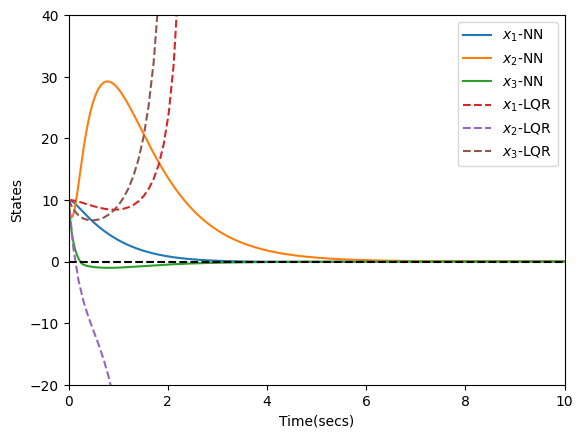

In [70]:
class closed_loop(nn.Module):

    def __init__(self, controller):
        super(closed_loop, self).__init__()
        self.controller = controller
        self.K = torch.tensor(K).to(device).float()

    def forward(self,t, z):
        u_NN = controller(z.T)
        z1, z2, z3 = z
        zz= z.reshape(3,1)
        u = self.K @ z
        dz1 = -z1 + z3
        dz2 = z1**2 - z2 - 2*z1*z3 + z3
        dz3 = -z2 - u.squeeze(-1) + u_NN.squeeze(-1)
        dz =  torch.cat((dz1, dz2, dz3), dim=0).reshape(3,1) 
        return dz
    
closed_loop_pendulum = closed_loop(controller).to(device)
endtime = 10.0
n_exp = 1
time_vec = torch.linspace(0,endtime,int(endtime)*100).to(device)
plt.figure(3)
for idx in range(0,n_exp):
    # x0 = torch.tensor([[-torch.pi/2],[-torch.pi/4]]).to(device)
    min = 10 
    max = 10
    initial_positions_vector = np.random.uniform(low=min, high=max, size=(1,1))
    initial_velocity_vector  = np.random.uniform(low=min, high=max, size=(1,1))
    initial_velocity_vector2  = np.random.uniform(low=min, high=max, size=(1,1))
    z0_vector = torch.tensor(np.concatenate((initial_positions_vector,initial_velocity_vector,initial_velocity_vector2),axis=1).T).to(device).to(torch.float32)
    
    out = odeint(closed_loop_pendulum, z0_vector, time_vec, rtol=tol, atol=tol, method="rk4")
    # print(out.shape)
    plt.plot(time_vec.cpu(), out[:,0,:].cpu().detach().numpy())
    plt.plot(time_vec.cpu(), out[:,1,:].cpu().detach().numpy())
    plt.plot(time_vec.cpu(), out[:,2,:].cpu().detach().numpy())
    # plt.plot()

    # # plt.figure()
    # plt.plot()

plt.ylabel('States')
plt.plot(time_vector_lqr[0:25], z_temp_lqr[0:25,0],'--')
plt.plot(time_vector_lqr[0:25], z_temp_lqr[0:25,1],'--')
plt.plot(time_vector_lqr[0:25], z_temp_lqr[0:25,2],'--')
plt.legend(['$x_1$-NN','$x_2$-NN','$x_3$-NN','$x_1$-LQR','$x_2$-LQR','$x_3$-LQR'])
plt.plot(time_vec.cpu(), torch.ones_like(time_vec.cpu())*0.0, 'k--')
plt.ylim([-20,40])
plt.xlim([0,10])
plt.xlabel('Time(secs)')
plt.savefig('/home/mzakwan/ACC2023/ian_manchester_unstable.pdf')



In [13]:
print(out[-1,0,:])
print(torch.pi/4)

tensor([-0.0016], device='cuda:2', grad_fn=<SliceBackward0>)
0.7853981633974483
